In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import nan
from topology import get_lognorm_hist, setup_topology
import random
import timeit
import statistics
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from leach import LeachSolver
from mst_prim import prim_mst
from nemo import NemoSolver
import seaborn as sns
import topology
import util

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)
avg = 50

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
X_dim = [-10, 110]
Y_dim = [-60, 60]

H, bins = get_lognorm_hist()

In [3]:
# assign nodes to previous clustering alg
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

iterations = 100
slot_col = "capacity_100"
W = 80
L = 100

opt_k = 0
#topology_sizes = [100, 1000, 10000, 100000, 500000, 1000000]
topology_sizes = [100, 1000]
weight_cols = ["weight_1", "weight_2", "weight"]
c_capacity = 100

In [4]:
topologies = []
for tsize in topology_sizes:
    print("Creating topology with size", tsize)
    device_number = tsize + 1
    max_resources = device_number * avg - 100
    centers = int(max(0.01 * tsize, 40))

    coords_df = topology.coords_sim(tsize, centers, X_dim_range, Y_dim_range, seed)
    coord_dict = {"sim": coords_df}

    df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                              weights=(1, avg * 2), dist="lognorm",
                                                              with_clustering=False)
    prim_df, c_coords, base_col, slot_columns = df_dict_topologies["sim"]
    prim_df["weight_1"] = 1
    prim_df["weight_2"] = 2

    # clustering
    no_cluster = int(0.1 * device_number)
    prim_df = topology.add_knn_labels(prim_df, no_cluster)

    topologies.append((tsize, prim_df, prim_df[["x", "y"]].to_numpy()))

Creating topology with size 100
Creating df for sim
Done
Creating topology with size 1000
Creating df for sim
Done


In [5]:
df = topologies[0][1]
df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,weight_1,weight_2,cluster
0,43.598138,-42.730447,0.000000,coordinator,9223372036854775807,0,100,100,100,100,...,100,100,100,100,100,100,100,1,2,-1
1,69.906805,-9.774109,42.169493,worker,9223372036854775807,1,50,48,50,52,...,49,47,41,35,18,16,19,1,2,7
2,5.903627,-15.356874,46.585283,worker,9223372036854775807,1,50,49,54,59,...,52,65,29,27,35,78,60,1,2,0
3,87.239519,32.769109,87.205235,worker,9223372036854775807,5,50,48,50,50,...,56,51,58,23,16,158,125,1,2,5
4,27.390694,52.297316,96.399984,worker,9223372036854775807,2,50,48,50,45,...,43,42,35,37,18,11,5,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,52.542492,-43.901647,9.020708,worker,9223372036854775807,7,50,51,48,42,...,54,58,44,39,120,34,84,1,2,4
97,13.983649,-1.488339,50.773314,worker,9223372036854775807,5,50,53,55,42,...,40,45,42,27,136,26,56,1,2,3
98,8.723507,24.069629,75.355756,worker,9223372036854775807,6,50,48,50,52,...,52,76,29,46,25,11,5,1,2,9
99,31.014250,39.404065,83.092914,worker,9223372036854775807,10,50,50,48,42,...,46,36,29,23,18,13,5,1,2,2


## NEMO

In [6]:
nemo_full_dict = {}
nemo_re_dict = {}

# params for NEMO
capacity_col = "capacity_100"
re_opt_rounds = 10

for weight_col in weight_cols:
    nemo_full_weight = []
    nemo_re_weight = []

    for tsize, prim_df, coords in topologies:
        print("Running NEMO", prim_df.shape[0] - 1, ":", weight_col)
        # calc full placement
        nemoSolver = NemoSolver(prim_df, capacity_col, weight_col, max_levels=50, step_size=0.5, merge_factor=0.5)

        start_time = timeit.default_timer()
        df_dict, opt_dict, limits_dict = nemoSolver.nemo_full()
        elapsed = timeit.default_timer() - start_time
        nemo_full_weight.append(elapsed)

        # re-placement
        print("Recalc")
        removed = set()
        runtimes = []
        resource_limits = []
        reopt_levels = [] 
        
        for re_run in range(0, re_opt_rounds):
            # take a random cluster head to be replaced
            parents = list(df_dict["parent"].unique())
            old_node = parents[random.randint(0, len(parents) - 1)]

            if old_node == 0 or old_node in removed:
                continue
            removed.add(old_node)

            rnode = df_dict[df_dict["oindex"] == old_node]
            upstream_nodes = df_dict[df_dict["parent"] == old_node]["oindex"].to_numpy()
            downstream_nodes = rnode["parent"].to_numpy()

            opt = rnode[["x", "y"]].mean().to_numpy()
            df_dict.drop(rnode.index)

            # recompute
            # print("removing", old_node)
            start_time = timeit.default_timer()
            new_cluster_heads, resource_limit, reopt_level = nemoSolver.nemo_reoptimize(old_node,
                                                                                        upstream_nodes,
                                                                                        downstream_nodes,
                                                                                        opt=opt)
            elapsed = timeit.default_timer() - start_time
            runtimes.append(elapsed)
            resource_limits.append(resource_limit)
            reopt_levels.append(reopt_level)
            # print("Old node", old_node, "New nodes:", new_cluster_heads, elapsed)

        nemo_re_weight.append({"runtimes": runtimes, "limit": resource_limits, "level": reopt_levels})

    # calc the mean of all runs
    nemo_full_dict[weight_col] = nemo_full_weight
    nemo_re_dict[weight_col] = nemo_re_weight

print("Full runs:", nemo_full_dict)
print("Re-optimization:", nemo_re_dict)

Running NEMO 100 : weight_1
Recalc
Running NEMO 1000 : weight_1
Recalc
Running NEMO 100 : weight_2
Recalc
Leaf nodes affected, please rerun full NEMO
Running NEMO 1000 : weight_2
Recalc
Running NEMO 100 : weight
Recalc
Running NEMO 1000 : weight
Recalc
Leaf nodes affected, please rerun full NEMO
Full runs: {'weight_1': [0.042598759000043174, 2.154288790999999], 'weight_2': [0.10261483099998259, 1.2100498620000053], 'weight': [0.15139221200001884, 1.3828360710000425]}
Re-optimization: {'weight_1': [{'runtimes': [], 'limit': [], 'level': []}, {'runtimes': [0.01091865199998665, 0.0018565870000202267, 0.0014405149998992783, 0.006512470999950892, 0.011393188999932136, 0.0015664420000121027, 0.005891338999958862, 0.010038183000006029], 'limit': [False, False, False, False, False, False, False, False], 'level': [nan, nan, nan, nan, nan, nan, nan, nan]}], 'weight_2': [{'runtimes': [0.0043448420000231636, 0.004482863000021098, 0.008983997999962412, 0.006249296999953913, 0.005852006000054644, 0.

## LEACH

In [49]:
leach_full = []

for tsize, prim_df, coords in topologies:
    print("LEACH run with size", tsize)
    no_centroids = int(tsize * 0.1)

    leachSolver = LeachSolver(prim_df, no_centroids, coords, seed=seed)
    start_time = timeit.default_timer()
    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()
    elapsed = timeit.default_timer() - start_time
    leach_full.append(elapsed)

LEACH run with size 100
LEACH run with size 1000
LEACH run with size 10000
LEACH run with size 100000
LEACH run with size 500000
LEACH run with size 1000000


In [50]:
leach_full

[0.03354996000052779,
 0.3120724059999702,
 3.0932921789999455,
 29.595716148000065,
 146.82815027300057,
 275.6718253019999]

## MST

In [ ]:
mst_full = []

for tsize in topology_sizes:
    print("MST run with size", tsize)
    no_centroids = int(tsize * 0.1)
    device_number = tsize + 1
    max_resources = device_number * avg - 100
    c_capacity = 100
    prim_df, coords, c_coords, slot_columns, sums = setup_topology(H, max_resources, c_capacity, no_centroids,
                                                                   X_dim_range, Y_dim_range, device_number - 1, seed)

    start_time = timeit.default_timer()
    mst = prim_mst(coords)
    elapsed = timeit.default_timer() - start_time
    print("Time with", tsize, ":", elapsed)
    mst_full.append(elapsed)

MST run with size 100
Time with 100 : 0.021984475000863313
MST run with size 1000
Time with 1000 : 1.70713769699978
MST run with size 10000
Time with 10000 : 349.2534674090002
MST run with size 100000


In [ ]:
mst_full

## Plotting Results

In [13]:
full_opt_nemo = [0.1079521339997882, 0.622427074999905, 5.664643757999784, 59.286709083000005, 269.86223116500014,
                 570.7745339570006]
re_opt_nemo = [0.0025799939999160415, 0.0016037149998737732, 0.0018865340002776065, 0.0028179860000818735,
               0.006405561000065063, 0.014996855000390497]

opt_leach = [0.03354996000052779, 0.3120724059999702, 3.0932921789999455, 29.595716148000065, 146.82815027300057,
             275.6718253019999]

opt_mst = [0.021984475000863313, 1.70713769699978, 349.2534674090002, np.nan, np.nan, np.nan]
opt_card = [975, np.nan, np.nan, np.nan, np.nan, np.nan]

approaches = {
    "nemo full-optimization": full_opt_nemo,
    "nemo re-optimization": re_opt_nemo,
    "leach": opt_leach,
    "mst": opt_mst,
    "optimal": opt_card
}

color_list = sns.color_palette(n_colors=17)
colors = np.asarray(color_list.as_hex())
colors = {
    "nemo full-optimization": colors[6],
    "nemo re-optimization": "pink",
    "leach": colors[1],
    "mst": colors[2],
    "optimal": "blue"
}
styles = {
    "nemo full-optimization": ":",
    "nemo re-optimization": ":",
    "leach": "-",
    "mst": "--",
    "optimal": "."
}
markers = {
    "nemo full-optimization": "*",
    "nemo re-optimization": "*",
    "leach": "d",
    "mst": "v",
    "optimal": "x"
}

ValueError: x and y must be the same size

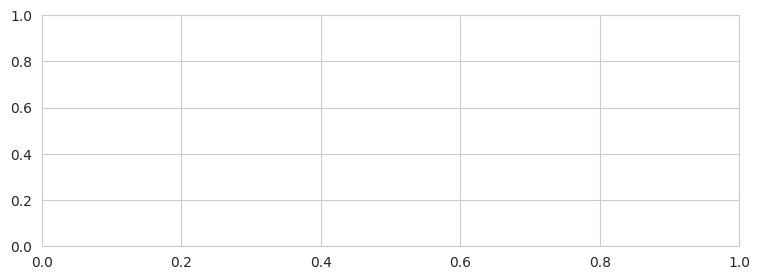

In [11]:
fig, ax = plt.subplots(figsize=(9, 3))

for k, v in approaches.items():
    # create a scatter plot
    ax.scatter(topology_sizes, v, label=k, s=100, alpha=0.8, marker=markers[k], color=colors[k])

    # calculate the linear regression line
    slope, intercept = np.polyfit(topology_sizes, v, 1)
    full_opt_line = np.poly1d((slope, intercept))(np.array(topology_sizes))
    # plot the linear regression line
    ax.plot(topology_sizes, full_opt_line, "--", alpha=0.8, color=colors[k])

# set the axis labels and title
ax.set_xlabel('number of nodes', fontsize=12)
ax.set_ylabel('time (s)', fontsize=12)

# Set the legend
ax.legend()
ax.ticklabel_format(style='plain', axis='x')

# Set the x-ticks and format the tick labels
xticks = [100, 100000, 500000, 1000000]
xtick_labels = [f"{xtick // 1000}k" if xtick < 1000000 else f"{xtick // 1000000}M" for xtick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Set the tick label format for the x-axis
formatter = FuncFormatter(lambda x, pos: f"{x}" if x < 1000 else f"{x // 1000}k" if x < 1000000 else f"{x // 1000000}M")
ax.xaxis.set_major_formatter(formatter)

ax.set_ylim([-50, 1500])

plt.savefig("plots/scalability.svg", bbox_inches="tight")

# show the plot
plt.title('Optimization Time vs Topology Size')
plt.show()

### New

In [14]:
full_opt_nemo = {'weight_1': [0.03122546200029319, 0.9422580749996996], 'weight_2': [0.06374972999947204, 0.7748011739986396], 'weight': [0.09387418100050127, 0.9743769569995493]}

In [15]:
approaches = {"nemo full-optimization": full_opt_nemo}

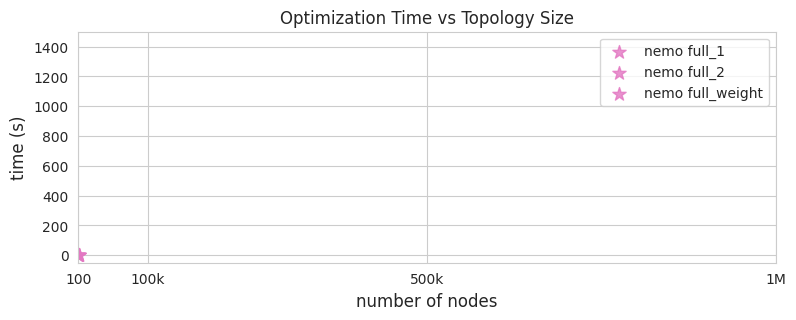

In [16]:
fig, ax = plt.subplots(figsize=(9, 3))

for k, v in approaches.items():
    if k == "nemo full-optimization":
        for weight, v in v.items():
            l = "nemo full_" + weight.replace("weight_", "")
            ax.scatter(topology_sizes, v, label=l, s=100, alpha=0.8, marker=markers[k], color=colors[k])
    else:
        # create a scatter plot
        ax.scatter(topology_sizes, v, label=k, s=100, alpha=0.8, marker=markers[k], color=colors[k])

        # calculate the linear regression line
        slope, intercept = np.polyfit(topology_sizes, v, 1)
        full_opt_line = np.poly1d((slope, intercept))(np.array(topology_sizes))
        # plot the linear regression line
        ax.plot(topology_sizes, full_opt_line, "--", alpha=0.8, color=colors[k])

# set the axis labels and title
ax.set_xlabel('number of nodes', fontsize=12)
ax.set_ylabel('time (s)', fontsize=12)

# Set the legend
ax.legend()
ax.ticklabel_format(style='plain', axis='x')

# Set the x-ticks and format the tick labels
xticks = [100, 100000, 500000, 1000000]
xtick_labels = [f"{xtick // 1000}k" if xtick < 1000000 else f"{xtick // 1000000}M" for xtick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Set the tick label format for the x-axis
formatter = FuncFormatter(lambda x, pos: f"{x}" if x < 1000 else f"{x // 1000}k" if x < 1000000 else f"{x // 1000000}M")
ax.xaxis.set_major_formatter(formatter)

ax.set_ylim([-50, 1500])

# plt.savefig("plots/scalability.svg", bbox_inches="tight")

# show the plot
plt.title('Optimization Time vs Topology Size')
plt.show()

In [17]:
from collections import Counter

In [18]:
re_opt_nemo = {'weight_1': [{'runtimes': [], 'limit': [], 'level': []}, {'runtimes': [0.006249088000913616, 0.006149933000415331, 0.0013934390008216724, 0.011968914997851243, 0.006146478001028299, 0.002282790999743156, 0.001969108998309821, 0.0017124229998444207, 0.0036683049984276295], 'limit': [False, False, False, False, False, False, False, False, False], 'level': [nan, nan, nan, nan, nan, nan, nan, nan, nan]}], 'weight_2': [{'runtimes': [0.002471146002790192, 0.002004979000048479, 0.007322289999137865, 0.0014884219999657944, 0.0025754540001798887, 0.0068225480026740115], 'limit': [False, False, False, False, False, False], 'level': [nan, nan, nan, nan, nan, 0]}, {'runtimes': [0.0010174659983022138, 0.0005753479999839328, 0.003159326999593759, 0.0031100390006031375, 0.0006308720003289636, 0.0071966550021898, 0.006583336999028688, 0.0026713199986261316, 0.011964058998273686], 'limit': [False, False, False, False, False, False, False, False, False], 'level': [nan, nan, nan, nan, nan, nan, nan, nan, nan]}], 'weight': [{'runtimes': [0.004765533001773292, 0.003935801996703958, 0.0010214440007985104, 0.09083432999977958, 0.0054707369999960065, 0.0036803989969484974, 0.002335373999812873, 0.00434497499736608], 'limit': [False, False, False, False, False, False, False, False], 'level': [nan, nan, nan, 1, nan, nan, nan, nan]}, {'runtimes': [0.00480218500160845, 0.007837681001547026, 0.09442969800147694, 0.10849012700055027, 0.1475395120032772, 0.0077275250005186535, 0.721535574997688, 0.0068186669996066485, 0.00862098200013861, 0.005052538999734679], 'limit': [False, False, False, False, False, False, False, False, False, False], 'level': [nan, nan, 2, 2, 2, nan, 1, 0, nan, nan]}]}

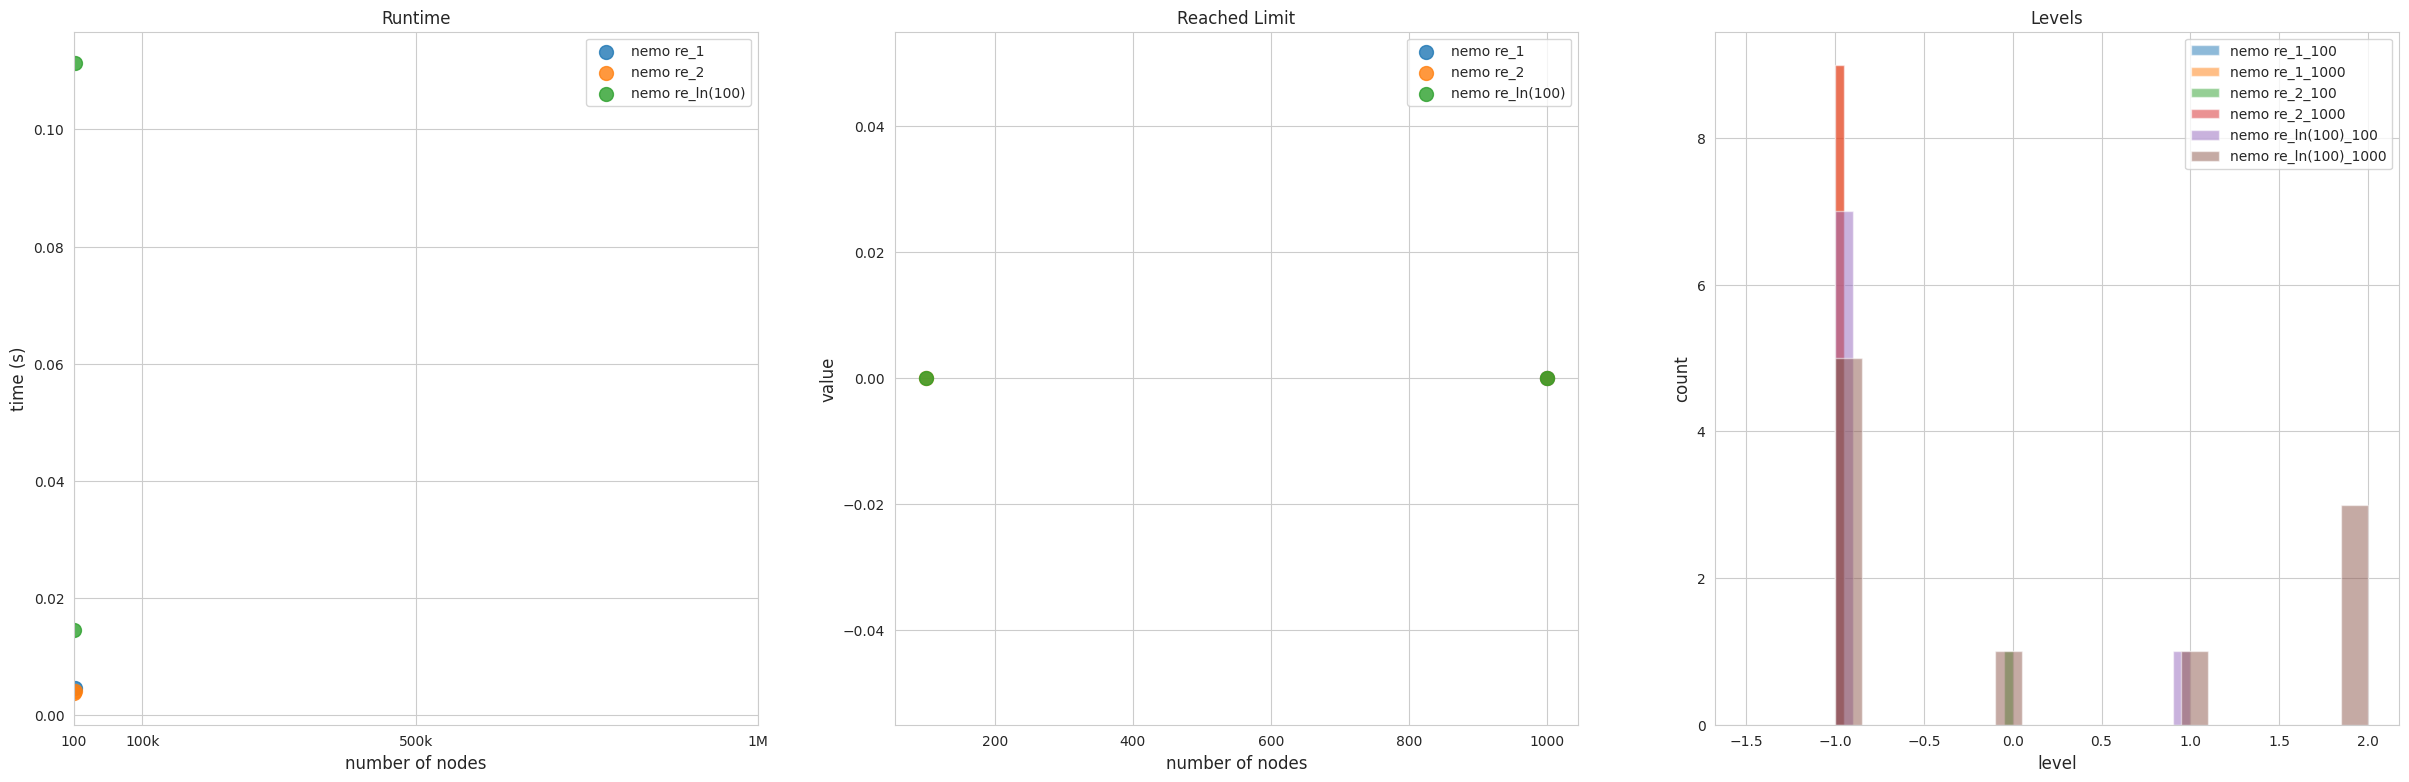

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 9))

for weight, topo_list in re_opt_nemo.items():
    runtimes = [np.mean(x["runtimes"]) if x["runtimes"] else np.nan for x in topo_list]
    limit_reached = [x["limit"].count(True) if x["limit"] else np.nan for x in topo_list]
    levels = [x["level"] for x in topo_list]
    
    l = "nemo re_" + weight.replace("weight_", "")
    l = l.replace("weight", "ln(100)")
    k = "nemo re-optimization"
    ax1.scatter(topology_sizes, runtimes, label=l, s=100, alpha=0.8)
    ax2.scatter(topology_sizes, limit_reached, label=l, s=100, alpha=0.8)
    for i, data in enumerate(levels):
        data = [-1 if np.isnan(x) else x for x in data]
        ax3.hist(data, bins=20, alpha=0.5, label=l + "_" + str(topology_sizes[i]))
    

# set the axis labels and title
ax1.set_xlabel('number of nodes', fontsize=12)
ax1.set_ylabel('time (s)', fontsize=12)

# Set the legend
ax1.legend()
ax1.ticklabel_format(style='plain', axis='x')

# Set the x-ticks and format the tick labels
xticks = [100, 100000, 500000, 1000000]
xtick_labels = [f"{xtick // 1000}k" if xtick < 1000000 else f"{xtick // 1000000}M" for xtick in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels)

# Set the tick label format for the x-axis
formatter = FuncFormatter(lambda x, pos: f"{x}" if x < 1000 else f"{x // 1000}k" if x < 1000000 else f"{x // 1000000}M")
ax1.xaxis.set_major_formatter(formatter)
ax1.set_title('Runtime')

# axis 2
ax2.set_title('Reached Limit')
ax2.set_xlabel('number of nodes', fontsize=12)
ax2.set_ylabel('value', fontsize=12)
ax2.legend()

# axis 2
ax3.set_title('Levels')
ax3.set_xlabel('level', fontsize=12)
ax3.set_ylabel('count', fontsize=12)
ax3.legend()

plt.show()